In [1]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "serif"
import torch
from astropy.visualization import make_lupton_rgb
from hydra import compose, initialize
from hydra.utils import instantiate

from images_to_maps.dc2.utils import unpack_dict
from images_to_maps.utils.weighted_avg_ellip import compute_weighted_avg_ellip

with initialize(config_path="../", version_base=None):
    cfg = compose("config_train_npe")

**Load image and catalog**

In [2]:
dc2 = instantiate(cfg.surveys.dc2)
dc2._load_image_and_bg_files_list()

98

In [3]:
# this cell takes approximately one minute on a GPU
image_index = 1
result_dict = dc2.load_image_and_catalog(image_index)

image = result_dict["inputs"]["image"]
tile_dict = result_dict["tile_dict"]
psf_params = result_dict["inputs"]["psf_params"]

shear1 = tile_dict["shear1_sum"] / (
    tile_dict["shear1_count"]
    + (tile_dict["shear1_count"] == 0) * torch.ones_like(tile_dict["shear1_count"])
)
shear2 = tile_dict["shear2_sum"] / (
    tile_dict["shear2_count"]
    + (tile_dict["shear2_count"] == 0) * torch.ones_like(tile_dict["shear2_count"])
)
convergence = tile_dict["convergence_sum"] / (
    tile_dict["convergence_count"]
    + (tile_dict["convergence_count"] == 0) * torch.ones_like(tile_dict["convergence_count"])
)
ellip1_lensed = tile_dict["ellip1_lensed_sum"] / (
    tile_dict["ellip1_lensed_count"]
    + (tile_dict["ellip1_lensed_count"] == 0) * torch.ones_like(tile_dict["ellip1_lensed_count"])
)
ellip2_lensed = tile_dict["ellip2_lensed_sum"] / (
    tile_dict["ellip2_lensed_count"]
    + (tile_dict["ellip2_lensed_count"] == 0) * torch.ones_like(tile_dict["ellip2_lensed_count"])
)
ellip_lensed = torch.stack((ellip1_lensed.squeeze(-1), ellip2_lensed.squeeze(-1)), dim=-1)
ellip1_lsst = tile_dict["ellip1_lsst_sum"] / (
    tile_dict["ellip1_lsst_count"]
    + (tile_dict["ellip1_lsst_count"] == 0) * torch.ones_like(tile_dict["ellip1_lsst_count"])
)
ellip2_lsst = tile_dict["ellip2_lsst_sum"] / (
    tile_dict["ellip2_lsst_count"]
    + (tile_dict["ellip2_lsst_count"] == 0) * torch.ones_like(tile_dict["ellip2_lsst_count"])
)
ellip_lsst = torch.stack((ellip1_lsst.squeeze(-1), ellip2_lsst.squeeze(-1)), dim=-1)
redshift = tile_dict["redshift_sum"] / (
    tile_dict["redshift_count"]
    + (tile_dict["redshift_count"] == 0) * torch.ones_like(tile_dict["redshift_count"])
)
ra = tile_dict["ra_sum"] / (
    tile_dict["ra_count"] + (tile_dict["ra_count"] == 0) * torch.ones_like(tile_dict["ra_count"])
)
dec = tile_dict["dec_sum"] / (
    tile_dict["dec_count"] + (tile_dict["dec_count"] == 0) * torch.ones_like(tile_dict["dec_count"])
)

tile_dict["shear_1"] = shear1
tile_dict["shear_2"] = shear2
tile_dict["convergence"] = convergence
tile_dict["ellip_lensed"] = ellip_lensed
tile_dict["ellip_lsst"] = ellip_lsst
tile_dict["ellip_lsst_wavg"] = compute_weighted_avg_ellip(
    tile_dict, dc2.avg_ellip_kernel_size, dc2.avg_ellip_kernel_sigma
)
tile_dict["redshift"] = redshift
tile_dict["ra"] = ra
tile_dict["dec"] = dec

data_splits = dc2.split_image_and_tile_cat(image, tile_dict, tile_dict.keys(), psf_params)

data_to_cache = unpack_dict(data_splits)

**Render the image**

In [4]:
image = data_to_cache[0]["images"]

In [5]:
def create_rgb(image, bgr=[1, 2, 3], stretch=1, Q=8, scale=[0.35, 0.45, 0.6]):
    if scale is None:
        r_im = image[bgr[2]]
        g_im = image[bgr[1]]
        b_im = image[bgr[0]]
    else:
        # manually re-scaling the images here
        r_im = image[bgr[2]] * scale[0]
        g_im = image[bgr[1]] * scale[1]
        b_im = image[bgr[0]] * scale[2]

    rgb = make_lupton_rgb(image_r=r_im, image_g=g_im, image_b=b_im, stretch=stretch, Q=Q)

    return rgb

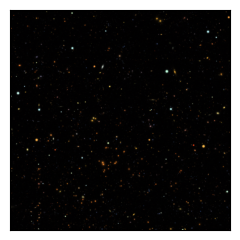

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))
_ = ax.imshow(create_rgb(image, stretch=1, Q=4, scale=[0.35, 0.45, 0.6]), origin="lower")
_ = ax.set_xticks([])
_ = ax.set_yticks([])

fig.tight_layout()

fig.savefig("figures/dc2image.png", dpi=600, transparent=True, bbox_inches="tight", pad_inches=0)

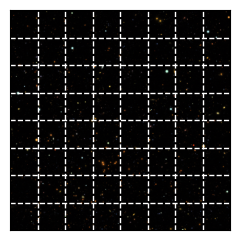

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))
_ = ax.imshow(create_rgb(image, stretch=1, Q=4, scale=[0.35, 0.45, 0.6]), origin="lower")
_ = ax.invert_xaxis()
_ = ax.set_xticks([])
_ = ax.set_yticks([])
_ = ax.vlines(
    x=[256 * c for c in range(1, 2048 // 256)],
    ymin=0,
    ymax=2048,
    color="white",
    linestyle="dashed",
    linewidth=1,
)
_ = ax.hlines(
    y=[256 * c for c in range(1, 2048 // 256)],
    xmin=0,
    xmax=2048,
    color="white",
    linestyle="dashed",
    linewidth=1,
)
_ = ax.set_xlim(0, 2048)
_ = ax.set_ylim(0, 2048)

fig.tight_layout()

fig.savefig(
    "figures/dc2image_grid.png", dpi=600, transparent=True, bbox_inches="tight", pad_inches=0
)

**Plot shear and convergence**

In [8]:
shear1 = data_to_cache[0]["tile_catalog"]["shear_1"].squeeze()
shear2 = data_to_cache[0]["tile_catalog"]["shear_2"].squeeze()
convergence = data_to_cache[0]["tile_catalog"]["convergence"].squeeze()

In [9]:
galaxy_shear1 = torch.zeros_like(result_dict["other_info"]["full_cat"]["shear1"].squeeze())
galaxy_shear2 = torch.zeros_like(result_dict["other_info"]["full_cat"]["shear2"].squeeze())
galaxy_convergence = torch.zeros_like(
    result_dict["other_info"]["full_cat"]["convergence"].squeeze()
)
galaxy_plocs = torch.zeros_like(result_dict["other_info"]["full_cat"]["plocs_binned"].squeeze())

In [10]:
plocs_mask = (result_dict["other_info"]["full_cat"]["plocs_binned"].squeeze() <= 2048).all(dim=1)
plocs_mask *= (result_dict["other_info"]["full_cat"]["plocs_binned"].squeeze() != 0).all(dim=1)

In [11]:
for b in range(galaxy_plocs.shape[-1]):
    num = plocs_mask[:, b].sum()
    galaxy_shear1[:num, b] = result_dict["other_info"]["full_cat"]["shear1"].squeeze()[:, b][
        plocs_mask[:, b]
    ]
    galaxy_shear2[:num, b] = result_dict["other_info"]["full_cat"]["shear2"].squeeze()[:, b][
        plocs_mask[:, b]
    ]
    galaxy_convergence[:num, b] = result_dict["other_info"]["full_cat"]["convergence"].squeeze()[
        :, b
    ][plocs_mask[:, b]]
    galaxy_plocs[:num, :, b] = result_dict["other_info"]["full_cat"]["plocs_binned"].squeeze()[
        :, :, b
    ][plocs_mask[:, b]]

In [12]:
n = (galaxy_plocs != 0).all(1).sum(0)

Per-galaxy:

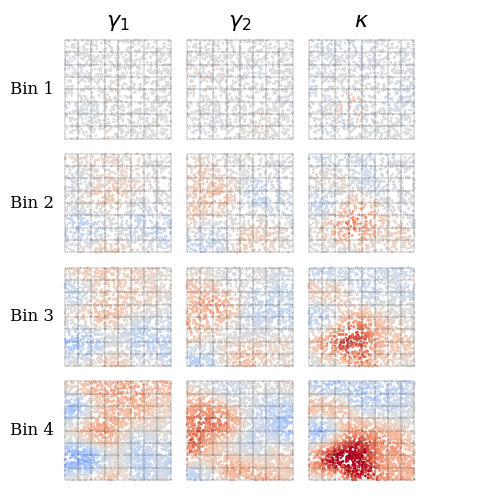

In [13]:
fig, ax = plt.subplots(4, 3, figsize=(4, 5))
alpha = 1
s = 1
fontsize = 12
cmap = "coolwarm"
vmin = -0.1
vmax = 0.1

for b in range(4):
    idx = torch.randint(0, n[b], size=[n[b] // 4])
    _ = ax[b, 0].scatter(
        galaxy_plocs[idx, 1, b],
        galaxy_plocs[idx, 0, b],
        c=galaxy_shear1[idx, b],
        vmin=vmin,
        vmax=vmax,
        alpha=alpha,
        s=s,
        cmap=cmap,
    )
    if b == 0:
        _ = ax[b, 0].set_title(r"$\gamma_1$", fontsize=16)

    _ = ax[b, 1].scatter(
        galaxy_plocs[idx, 1, b],
        galaxy_plocs[idx, 0, b],
        c=galaxy_shear2[idx, b],
        vmin=vmin,
        vmax=vmax,
        alpha=alpha,
        s=s,
        cmap=cmap,
    )
    if b == 0:
        _ = ax[b, 1].set_title(r"$\gamma_2$", fontsize=16)

    conv = ax[b, 2].scatter(
        galaxy_plocs[idx, 1, b],
        galaxy_plocs[idx, 0, b],
        c=galaxy_convergence[idx, b],
        vmin=vmin,
        vmax=vmax,
        alpha=alpha,
        s=s,
        cmap=cmap,
    )
    if b == 0:
        _ = ax[b, 2].set_title(r"$\kappa$", fontsize=16)

_ = ax[0, 0].set_ylabel("Bin 1", fontsize=fontsize, labelpad=20, rotation=0, y=0.425)
_ = ax[1, 0].set_ylabel("Bin 2", fontsize=fontsize, labelpad=20, rotation=0, y=0.425)
_ = ax[2, 0].set_ylabel("Bin 3", fontsize=fontsize, labelpad=20, rotation=0, y=0.425)
_ = ax[3, 0].set_ylabel("Bin 4", fontsize=fontsize, labelpad=20, rotation=0, y=0.425)

for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])
    a.vlines(
        x=[256 * c for c in range(2048 // 256 + 1)],
        ymin=0,
        ymax=2048,
        color="black",
        linestyle="dashed",
        linewidth=0.25,
    )
    a.hlines(
        y=[256 * c for c in range(2048 // 256 + 1)],
        xmin=0,
        xmax=2048,
        color="black",
        linestyle="dashed",
        linewidth=0.25,
    )
    for spine in a.spines.values():
        spine.set_visible(False)

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.975, 0.05, 0.01, 0.9])
cbar_ax.tick_params(labelsize=0.5 * fontsize, width=0.25)
cbar = fig.colorbar(conv, cax=cbar_ax)
cbar.outline.set_linewidth(0.25)
cbar.solids.set_visible(False)
cbar.outline.set_visible(False)
cbar_ax.tick_params(color="none", labelcolor="none")

fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.05, hspace=0.05)

fig.savefig(
    "figures/dc2maps_pergalaxy.png", dpi=600, transparent=True, bbox_inches="tight", pad_inches=0
)

Averaged within each tile:

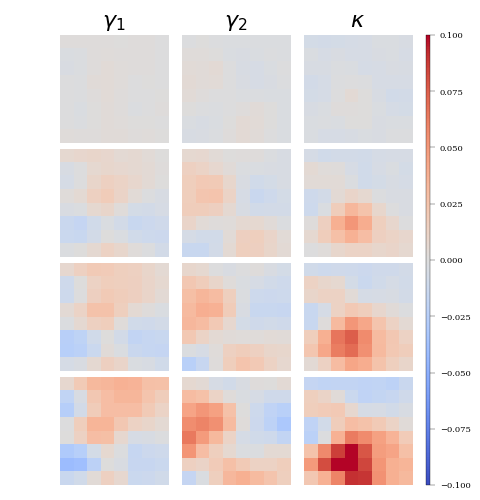

In [14]:
fig, ax = plt.subplots(4, 3, figsize=(4, 5))
alpha = 1
fontsize = 12
cmap = "coolwarm"
vmin = -0.1
vmax = 0.1

for b in range(4):
    _ = ax[b, 0].imshow(shear1[..., b], cmap=cmap, vmin=vmin, vmax=vmax, origin="lower")
    if b == 0:
        _ = ax[b, 0].set_title(r"$\gamma_1$", fontsize=16)

    _ = ax[b, 1].imshow(shear2[..., b], cmap=cmap, vmin=vmin, vmax=vmax, origin="lower")
    if b == 0:
        _ = ax[b, 1].set_title(r"$\gamma_2$", fontsize=16)

    conv = ax[b, 2].imshow(convergence[..., b], cmap=cmap, vmin=vmin, vmax=vmax, origin="lower")
    if b == 0:
        _ = ax[b, 2].set_title(r"$\kappa$", fontsize=16)

_ = ax[0, 0].set_ylabel("Bin 1", fontsize=fontsize, labelpad=20, rotation=0, y=0.425, alpha=0)
_ = ax[1, 0].set_ylabel("Bin 2", fontsize=fontsize, labelpad=20, rotation=0, y=0.425, alpha=0)
_ = ax[2, 0].set_ylabel("Bin 3", fontsize=fontsize, labelpad=20, rotation=0, y=0.425, alpha=0)
_ = ax[3, 0].set_ylabel("Bin 4", fontsize=fontsize, labelpad=20, rotation=0, y=0.425, alpha=0)

for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])
    for spine in a.spines.values():
        spine.set_visible(False)

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.975, 0.05, 0.01, 0.9])
cbar_ax.tick_params(labelsize=0.5 * fontsize, width=0.25)
cbar = fig.colorbar(conv, cax=cbar_ax)
cbar.outline.set_linewidth(0.25)

fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.05, hspace=0.05)

fig.savefig("figures/dc2maps.png", dpi=600, transparent=True, bbox_inches="tight", pad_inches=0)